In [116]:
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-learn

In [117]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import copy

## Sprint 1 – action classification through key points

Workflow:
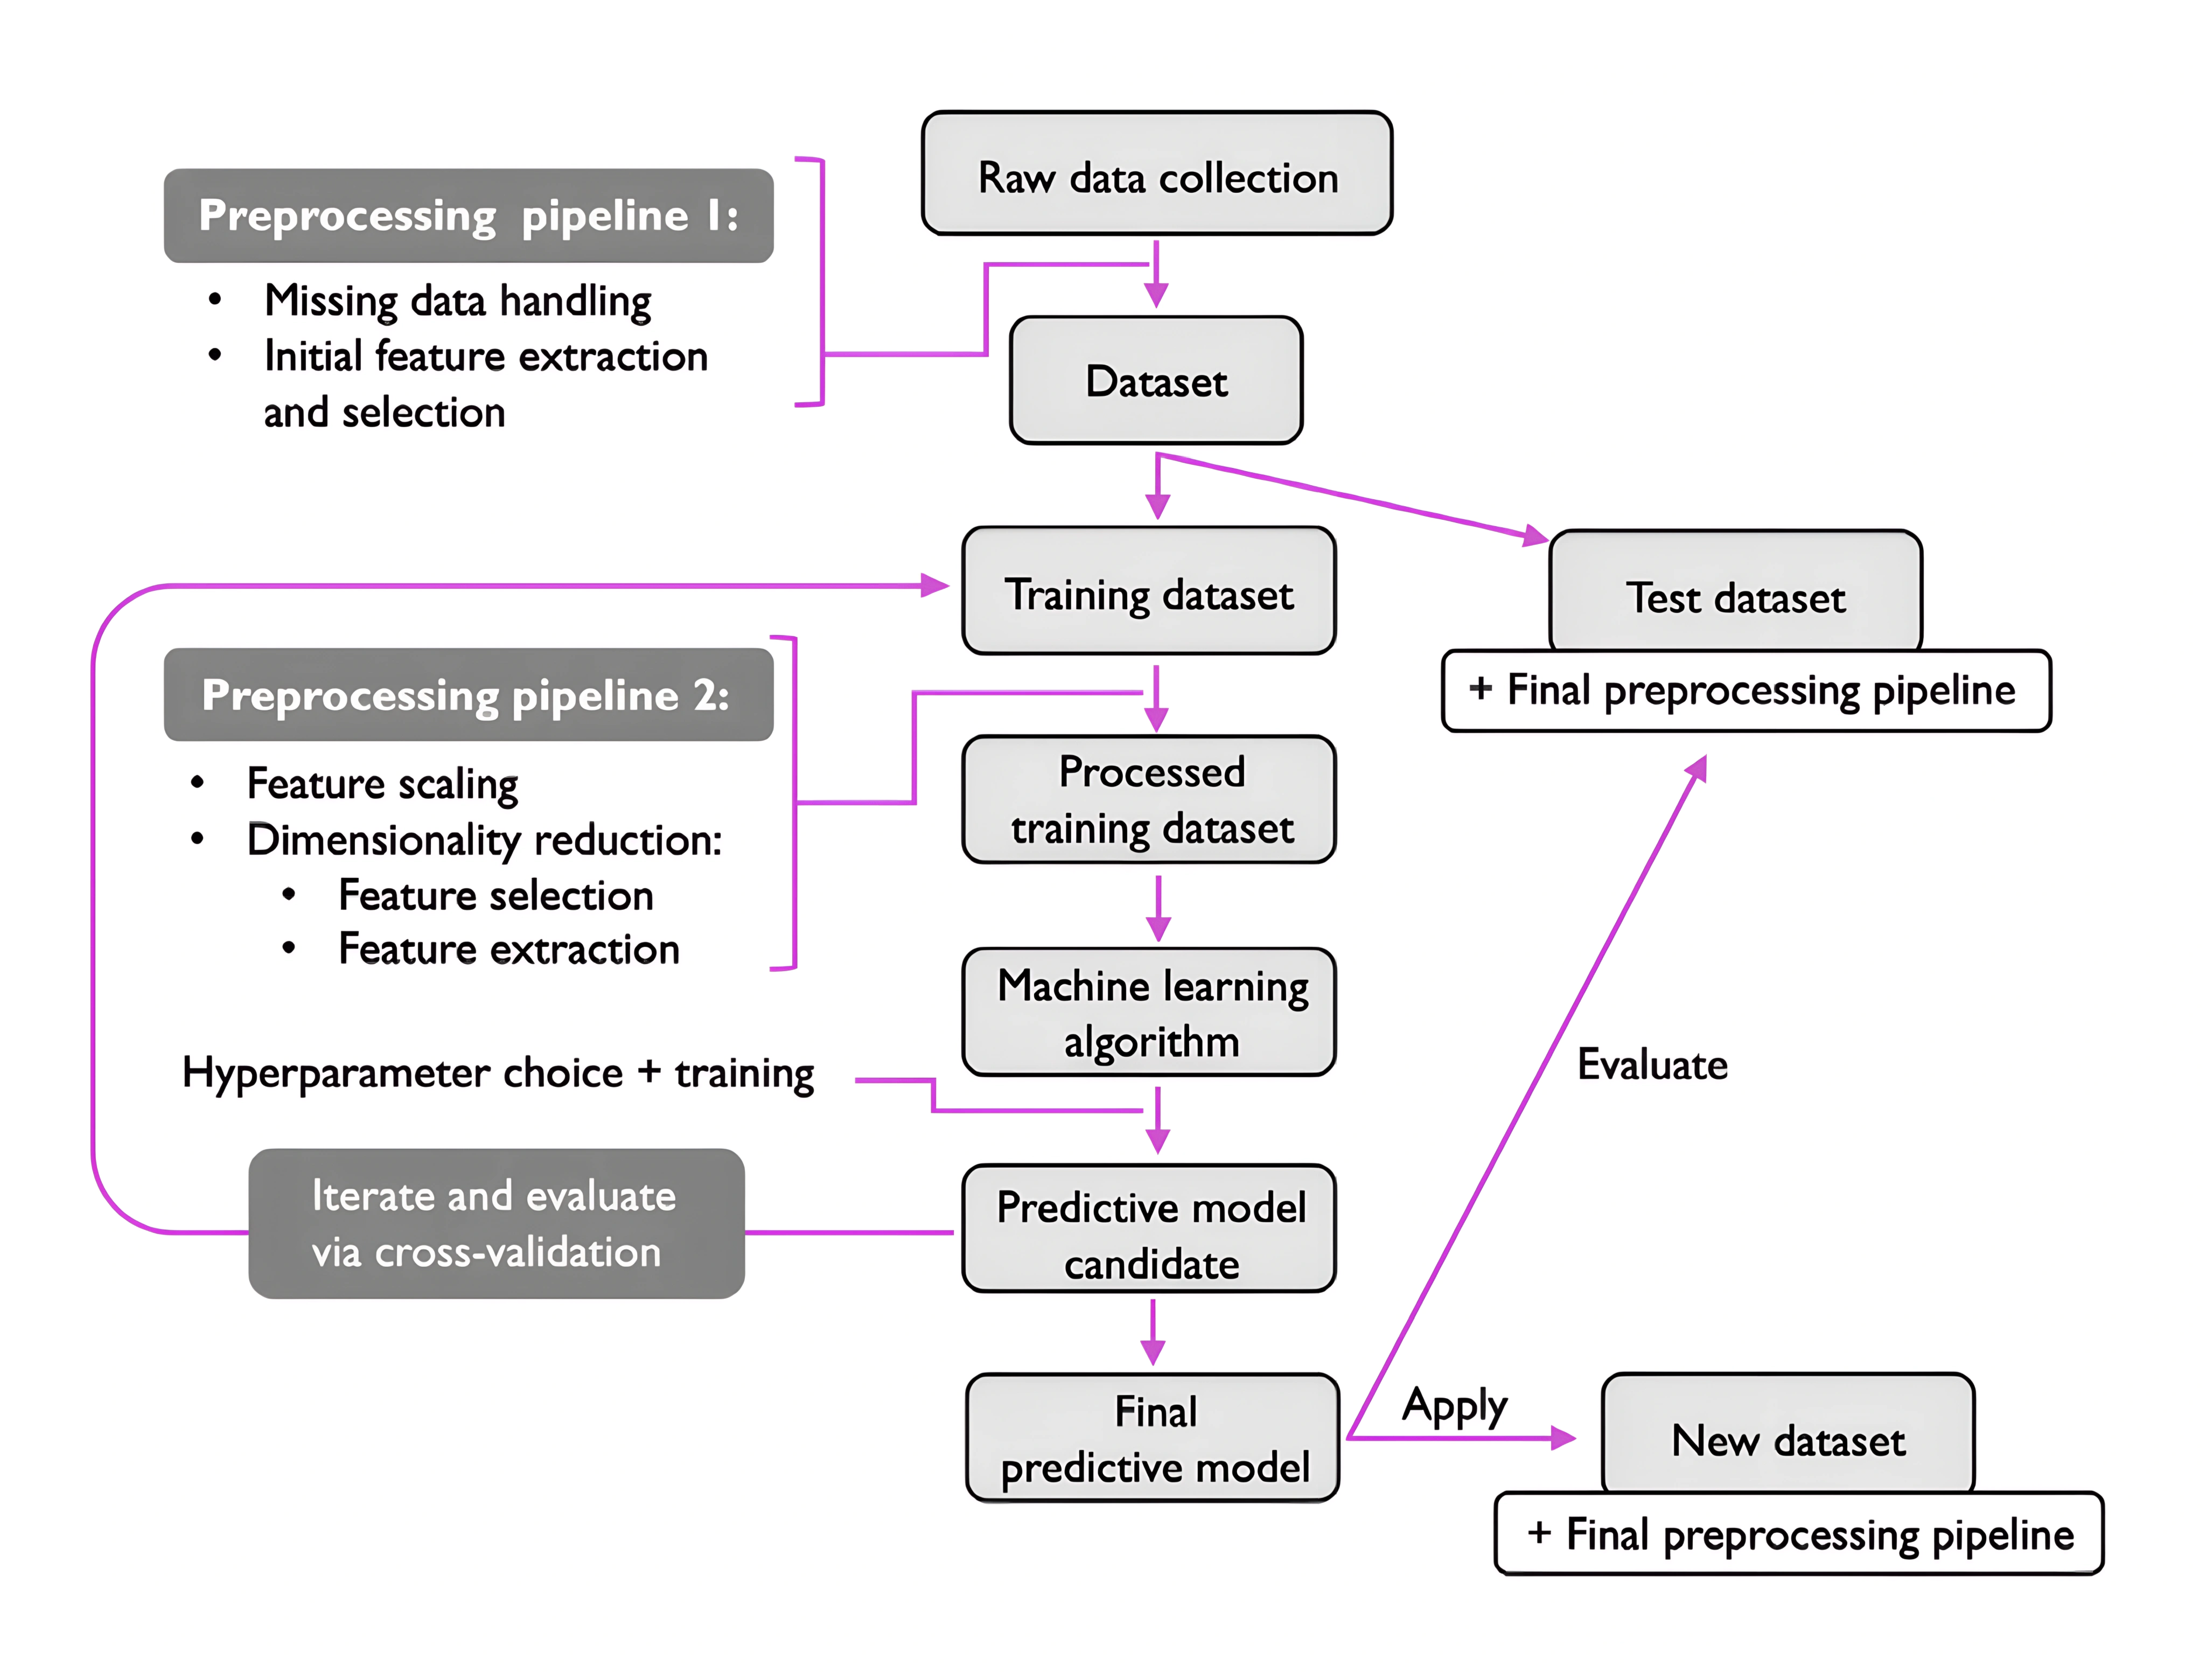

## Helper functions

## Exploratory data analysis


The data file names consist of the action that was performed by which group it was performed and the recording of which student of that group. The same number does not always refer to the same student of a certain group! To filter data by action simply look at the number after action-x. When you look at this you can filter what action you want to use. If you want to filter by group you can do the same thing but with group-x. The dataset is very balanced, because every action has been performed by each student in each group. And all recordings are 450 frames. This means that we have equal amounts of data for each action and from each student. 

In [118]:
def filter_files_by_action(action_number,files):
    return [file for file in files if f'action-{action_number}' in file]


# NOT USED
def filter_files_by_group(group_number,files):
    return [file for file in files if f'group-{group_number}' in file]

### Loading in data

In [119]:
data_dir = '../actions'
files = [file for file in os.listdir(data_dir) if file.endswith('.npy') and not file.startswith('._')]

In [120]:
def load_data(file_list):
    data = []
    for file in file_list:
        file_path = os.path.join(data_dir, file)
        try:
            data.append(np.load(file_path, allow_pickle=True))
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return np.concatenate(data, axis=0) if data else np.array([])

In [121]:
data = load_data(files)
print(data.shape)

(182700, 18, 3)


### Checking data

#### Is data balanced?

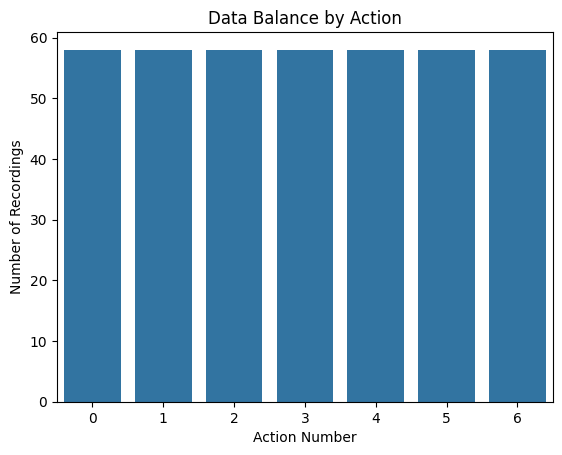

In [122]:
def check_balance(files):
    action_counts = {}
    for file in files:
        action_number = int(file.split('-')[1].split('-')[0])
        if action_number not in action_counts:
            action_counts[action_number] = 0
        action_counts[action_number] += 1
    return action_counts

balance = check_balance(files)

sns.barplot(x=list(balance.keys()), y=list(balance.values()))
plt.xlabel('Action Number')
plt.ylabel('Number of Recordings')
plt.title('Data Balance by Action')
plt.show()

#### What are the feature ranges? 

In [123]:
def calculate_feature_ranges(data):
    feature_ranges = {'x': [], 'y': [], 'confidence': []}
    
    for i in range(data.shape[1]):  
        x_values = data[:, i, 0]
        y_values = data[:, i, 1]
        confidence_values = data[:, i, 2]
        
        feature_ranges['x'].append((float(x_values.min()), float(x_values.max())))
        feature_ranges['y'].append((float(y_values.min()), float(y_values.max())))
        feature_ranges['confidence'].append((float(confidence_values.min()), float(confidence_values.max())))
    
    return feature_ranges

feature_ranges = calculate_feature_ranges(data)
print("X Ranges per keypoint:", feature_ranges['x'])
print("Y Ranges per keypoint:", feature_ranges['y'])
print("Confidence Ranges per keypoint:", feature_ranges['confidence'])
print(f"X Range: ({float(data[:, :, 0].min())}, {float(data[:, :, 0].max())})")
print(f"Y Range: ({float(data[:, :, 1].min())}, {float(data[:, :, 1].max())})")
print(f"Confidence Range: ({float(data[:, :, 2].min())}, {float(data[:, :, 2].max())})")


X Ranges per keypoint: [(-80.0, 666.5848429203033), (-34.166666666666686, 717.9166666666667), (-4.078280448913574, 717.9166666666667), (5.534295161565154, 717.9166666666667), (-80.0, 640.1781959533691), (-80.0, 717.9166666666667), (-80.0, 717.9166666666667), (-80.0, 639.0311431884766), (-80.0, 717.9166666666667), (-1.1754703521728516, 717.9166666666667), (11.666666666666629, 717.9166666666667), (-80.0, 717.9166666666667), (-80.0, 717.9166666666667), (-80.0, 717.9166666666667), (-80.0, 717.9166666666667), (-80.0, 659.1996665000916), (-80.0, 652.7320930957794), (-80.0, 659.4188709259033)]
Y Ranges per keypoint: [(0.43939208984375, 449.35094833374023), (22.480474948883057, 392.9576053619385), (25.18640661239624, 398.8351650238037), (33.23607659339905, 481.63822585344315), (-24.24833393096924, 527.8175045251846), (19.61255931854248, 427.6767387390137), (5.632223844528198, 470.7143142223358), (-23.455583930015564, 488.254843711853), (71.25, 476.0406231880188), (92.08333333333337, 532.373245

Weird to find negative values for the x and y, and values higher than 1 for the confidence, there are probably some weird frames

It is strange that some negative x and y values were found. We think this is because the key point recognition software made some errors. The confidence values range from 0.4 to 1.21, this is also weird since normally it is from 0 to 1, this might also be because of the way the recognition software works and assigns a confidence. 

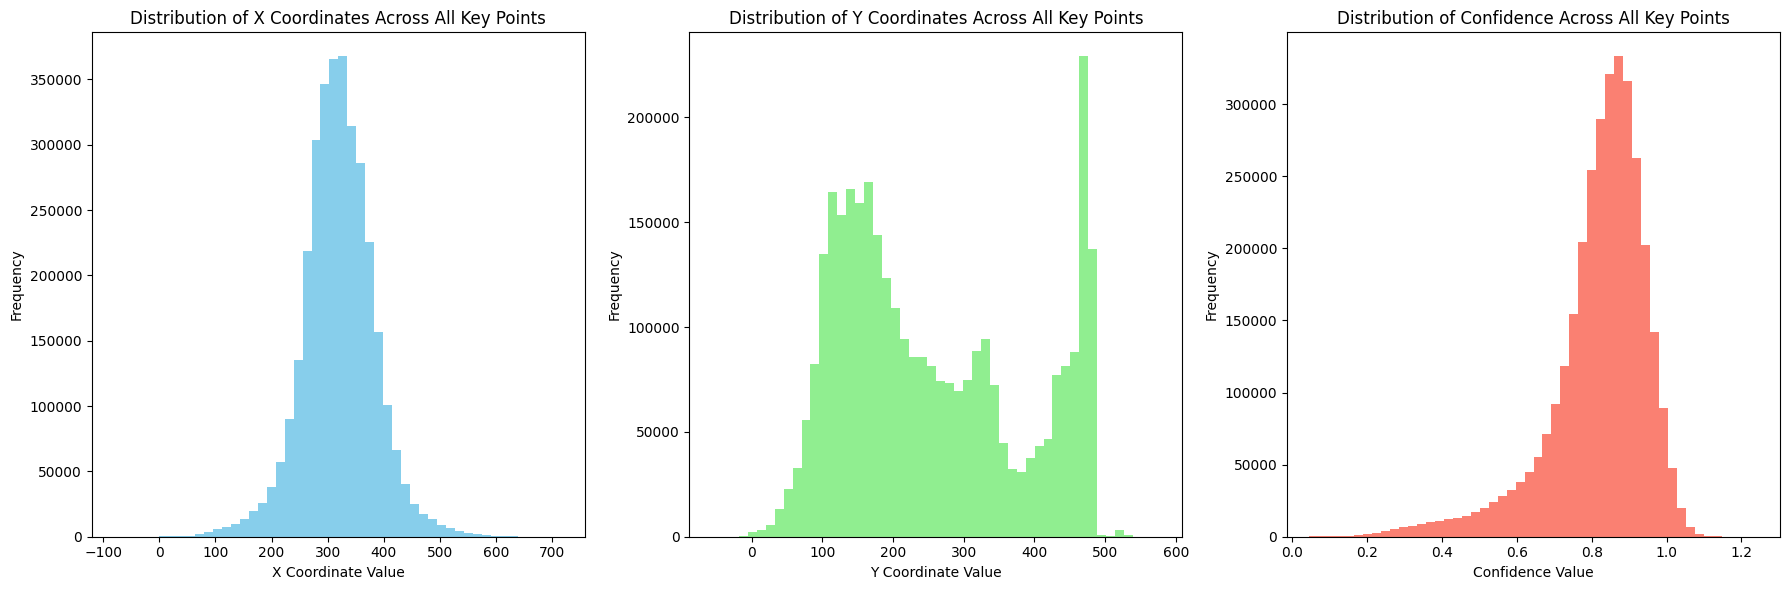

In [124]:
x_values = data[:, :, 0].flatten()
y_values = data[:, :, 1].flatten()
confidence_values = data[:, :, 2].flatten()

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(x_values, bins=50, color='skyblue')
plt.xlabel('X Coordinate Value')
plt.ylabel('Frequency')
plt.title('Distribution of X Coordinates Across All Key Points')

plt.subplot(1, 3, 2)
plt.hist(y_values, bins=50, color='lightgreen')
plt.xlabel('Y Coordinate Value')
plt.ylabel('Frequency')
plt.title('Distribution of Y Coordinates Across All Key Points')

plt.subplot(1, 3, 3)
plt.hist(confidence_values, bins=50, color='salmon')
plt.xlabel('Confidence Value')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Across All Key Points')

plt.tight_layout()
plt.show()

#### Ranges per action

In [125]:
def calculate_coordinate_ranges_per_action(files):
    data_per_action = {}
    for action_number in [0,1,2,3,4,5,6]:
        file_list = filter_files_by_action(action_number,files)
        data = load_data(file_list)
        if data.size > 0:
            data_per_action[action_number] = data
        else:
            print(f"No data found for action {action_number}")

    action_ranges = {}
    for action_number, data in data_per_action.items():
        x_min_values = np.min(data[:, :, 0], axis=0)
        x_max_values = np.max(data[:, :, 0], axis=0)
        x_ranges = x_max_values - x_min_values

        y_min_values = np.min(data[:, :, 1], axis=0)
        y_max_values = np.max(data[:, :, 1], axis=0)
        y_ranges = y_max_values - y_min_values

        action_ranges[action_number] = {
            'x_min': x_min_values,
            'x_max': x_max_values,
            'x_range': x_ranges,
            'y_min': y_min_values,
            'y_max': y_max_values,
            'y_range': y_ranges
        }
    return action_ranges


In [126]:
def plot_coordinate_ranges_per_action(action_ranges, keypoint_labels=None):
    actions = {0:"Jumping jacks",1:"Squat",2:"In-place running",3:"Side lunge",4:"Boxing",5:"Overhead press",6:"Bicep curl"}
    for action_number, ranges in action_ranges.items():
        
        num_keypoints = len(ranges['x_min'])
        keypoint_indices = np.arange(num_keypoints)

        
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle(f'Coordinate Ranges for Action {actions[action_number]}', fontsize=16)

        
        axes[0].bar(keypoint_indices, ranges['x_range'], bottom=ranges['x_min'],
                    color='skyblue', edgecolor='black')
        axes[0].set_xlabel('Key Point')
        axes[0].set_ylabel('X Coordinate Values')
        axes[0].set_title('Range of X Coordinate Values')
        axes[0].grid(axis='y', linestyle='--', alpha=0.7)
        axes[0].set_xticks(keypoint_indices)
        if keypoint_labels is not None:
            axes[0].set_xticklabels(keypoint_labels, rotation=45, ha='right')

        
        axes[1].bar(keypoint_indices, ranges['y_range'], bottom=ranges['y_min'],
                    color='lightgreen', edgecolor='black')
        axes[1].set_xlabel('Key Point')
        axes[1].set_ylabel('Y Coordinate Values')
        axes[1].set_title('Range of Y Coordinate Values')
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)
        axes[1].set_xticks(keypoint_indices)
        if keypoint_labels is not None:
            axes[1].set_xticklabels(keypoint_labels, rotation=45, ha='right')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
        plt.show()


In [127]:
keypoint_labels = [
    "Nose",
    "Neck",
    "Right Shoulder",
    "Right Elbow",
    "Right Wrist",
    "Left Shoulder",
    "Left Elbow",
    "Left Wrist",
    "Right Hip",
    "Right Knee",
    "Right Ankle",
    "Left Hip",
    "Left Knee",
    "Left Ankle",
    "Right Eye",
    "Left Eye",
    "Right Ear",
    "Left Ear"
]

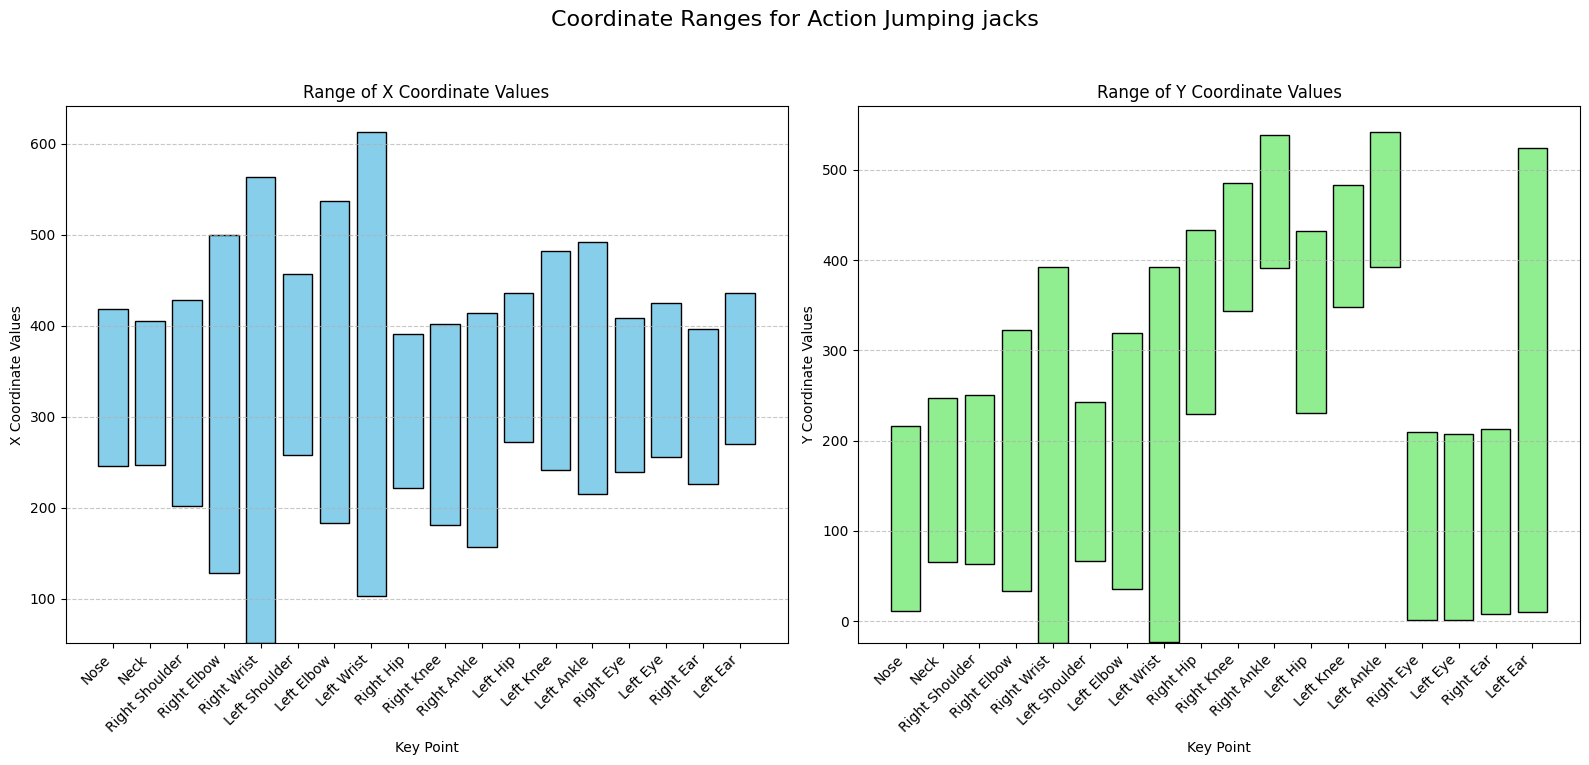

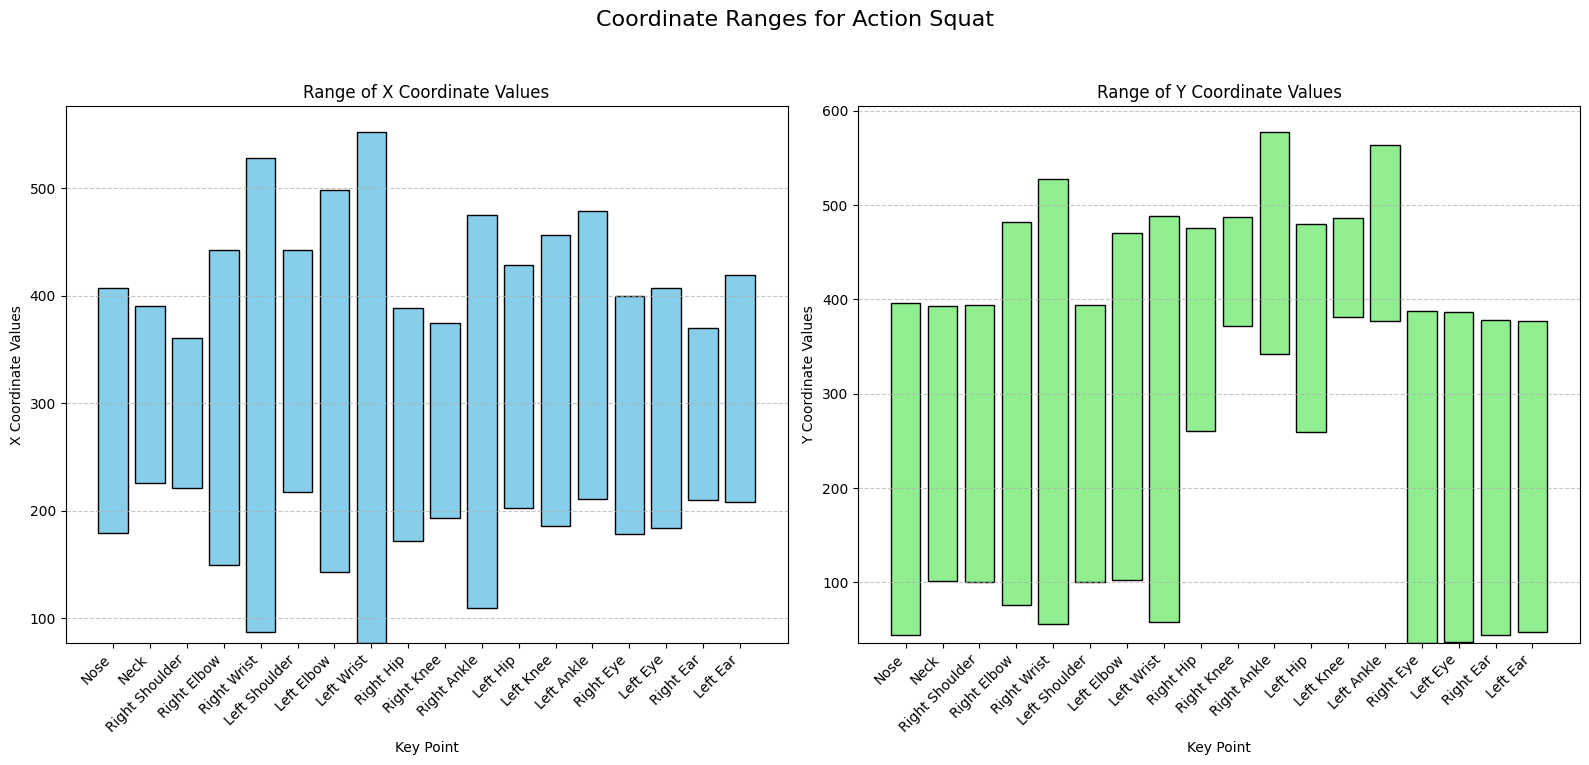

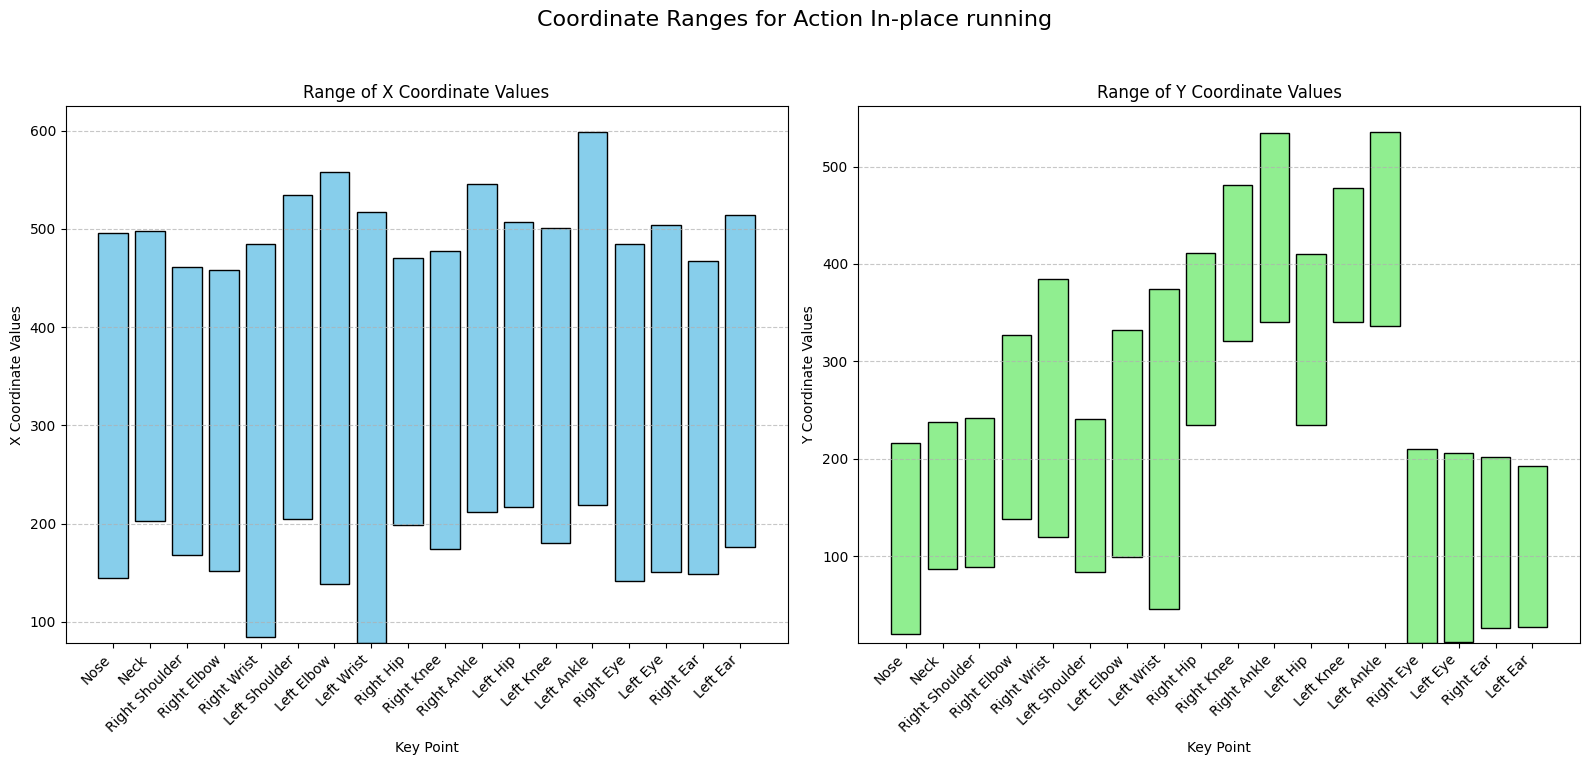

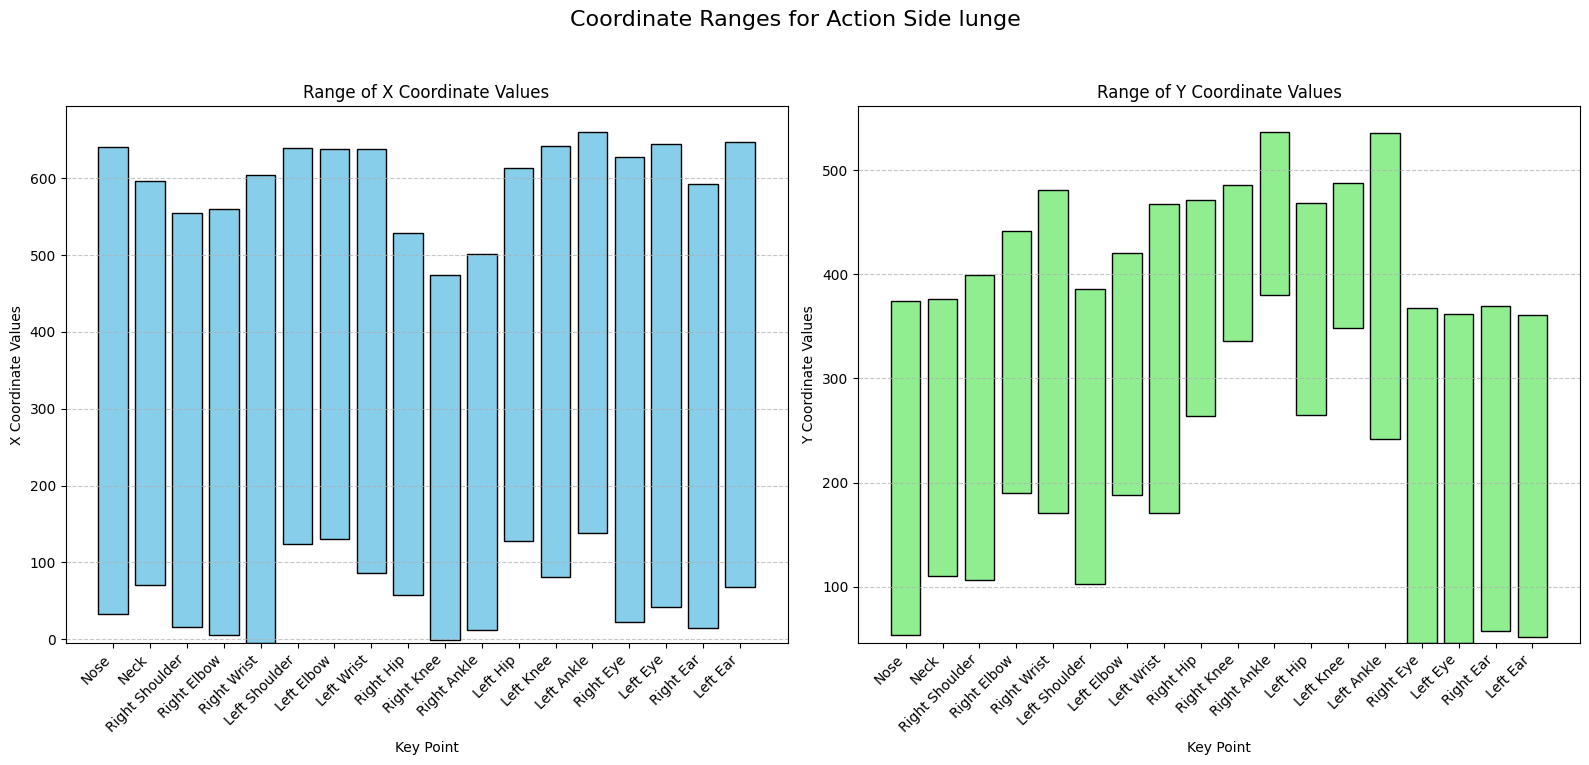

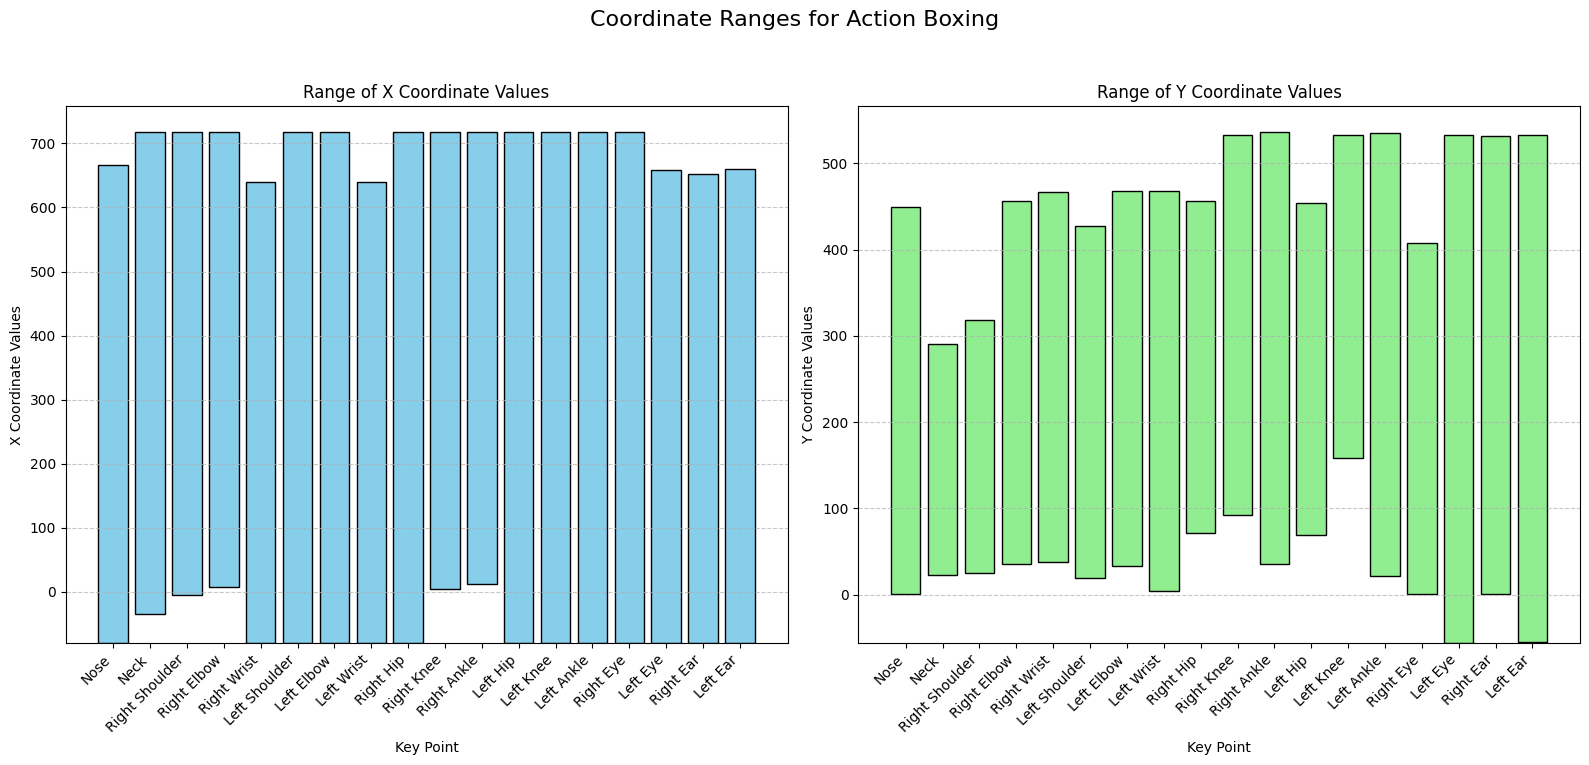

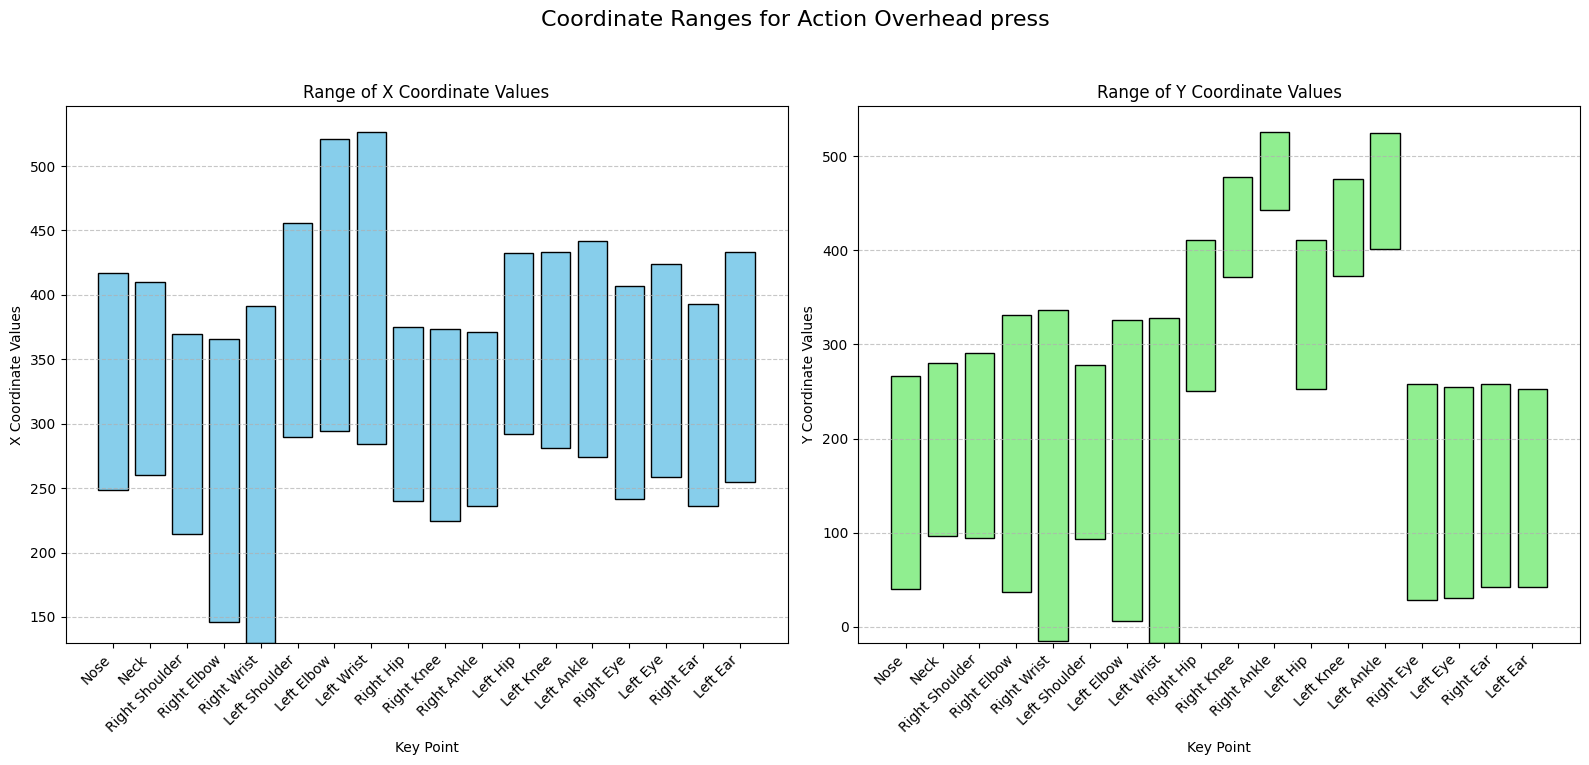

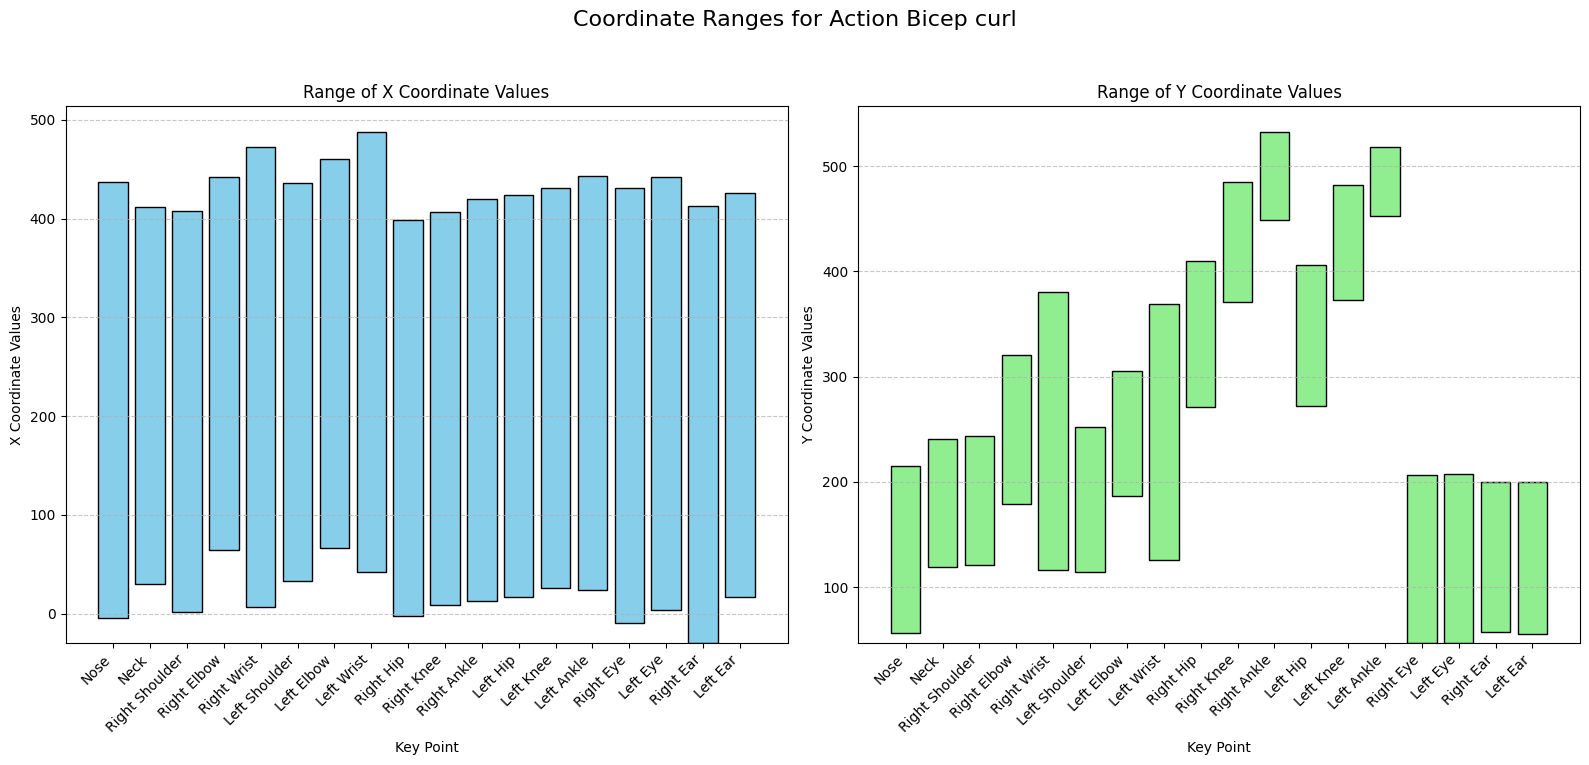

In [128]:
plot_coordinate_ranges_per_action(calculate_coordinate_ranges_per_action(files), keypoint_labels=keypoint_labels)

It is important to notice that the y ranges are reversed, a high y value means that they are closer to the ground.

These are the ranges per action. The ranges do make sense, lets look at the squat for example. The x ranges for the squat everything is quite uniform except for the wrists they have a large x range since not every student does a squat the same way. They move their hands to the left and right when the go down in the squat motion. The y values for the squat also make sense. The right hip and left hip both have a larger range than the knees since the knees normally don't move a lot during a squat but the hips do.

An other example is the overhead press where the y values show that the lower body barely moves but the arms and wrists do have a big range.

In [129]:
def calculate_variance_all(data):
    variance = {'x': [], 'y': []}

    for i in range(data.shape[1]):
        x_values = data[:, i, 0]
        y_values = data[:, i, 1]

        variance['x'].append(np.sqrt(np.var(x_values,axis=0)))
        variance['y'].append(np.sqrt(np.var(y_values,axis=0)))

    return variance

overall_variance = calculate_variance_all(data)
print("Overall Variance for Each Key Point:", overall_variance)

Overall Variance for Each Key Point: {'x': [48.73535112799586, 46.24918132221431, 50.35935776139084, 58.38434225411043, 72.00348546541099, 48.52498814710205, 56.30159700485159, 70.03800807653845, 45.96711248171957, 50.965130722777594, 51.5759206210089, 44.85180683416053, 49.270205968601005, 48.49509893426701, 48.531875295274794, 48.4515887441558, 48.35530971624635, 47.59537702040605], 'y': [47.853918258655696, 43.22234801670678, 43.683308137703115, 62.883263482183224, 92.18579248197264, 43.130151515806624, 61.678018337479436, 90.55054796607048, 34.014698023571604, 26.73494419030253, 14.0373210100789, 33.60482753913807, 25.11646874393973, 12.792276951551294, 47.67818674418136, 47.65317492884925, 46.32579073344594, 46.17762459649168]}


We calculated the variance for each key point over all the data first to see if the variances are logical or not.
The values are indeed logical for example the x variance for feature 4 which is the right wrist has the biggest variance. This makes sense since one of the movements is jumping jacks.
If we would want to reduce the variability we could normalize the recordings for 1 action for each recording.
These values are before normalizing the data to see if we can reduce the variance per keyfeature.

In [130]:
for i in range(0,7):
    action_files = filter_files_by_action(i,files)
    data = load_data(action_files)
    variance = calculate_variance_all(data)
    print(f"Action {i} Variance for Each Key Point:", variance)

Action 0 Variance for Each Key Point: {'x': [25.110654483582387, 24.170172155807908, 28.617662470062776, 43.78401663865262, 65.95032629923894, 26.309844193665846, 39.77679109387573, 60.44581568541778, 25.2757316172482, 31.22697858278441, 38.08836798607914, 24.749904198781493, 32.36252624681617, 37.43922814861165, 25.612455296926942, 25.187736394503588, 26.382860447190332, 25.33529408240452], 'y': [32.82742245142488, 31.50021643543817, 32.15135033200833, 56.73932804745157, 102.39820096702893, 30.970366590626465, 54.84569811040193, 99.11427730245039, 31.77757905184956, 28.682282895606953, 9.863483158912977, 31.297899421403734, 27.65990040687636, 9.249125053143187, 33.151129185497176, 32.884023886999906, 33.51012048472593, 32.768748453788696]}
Action 1 Variance for Each Key Point: {'x': [33.94898636579514, 24.79354439188649, 25.857687448747278, 43.43829705275355, 68.06478095992706, 36.35496125533211, 60.4074433776476, 85.81444305554305, 29.200919019597812, 28.553364635138564, 30.599439685

These are the variances for the values per action. These also make sense, action 3 which is the Side lunge has the biggest x variance.

### Split your data in a train set and a hold-out test set
We want the first 4 groups to be for the test data, and the rest for the training set.
We split it by group, because this was an easy way to divide the dataset in 2 subsets where the first 4 group numbers are always used in the test data set and the rest in the train data set.
This way around 86% of the data is for training and 14% for testing.

We also made sure to append full recordings to either the train or test set to prevent data leakage.


In [131]:
def split_data_dict(data_directory):
    file_names = os.listdir(data_directory)
    test_data = {}
    train_data = {}

    for file_name in file_names:
        action_label = int(file_name.split('-')[1]) 
        group_number = int(file_name.split('-')[3])
        
        data = np.load(os.path.join(data_directory, file_name))
        
        if 0 <= group_number < 4:
            if action_label not in test_data:
                test_data[action_label] = []
            test_data[action_label].append(data)
        else:
            if action_label not in train_data:
                train_data[action_label] = []
            train_data[action_label].append(data)
    
    print(f"Test set size: {sum(len(v) for v in test_data.values())} recordings")
    print(f"Training set size: {sum(len(v) for v in train_data.values())} recordings")
    
    return train_data, test_data

In [132]:
train_data, test_data = split_data_dict(data_dir)

Test set size: 56 recordings
Training set size: 350 recordings


### Preprocessing pipeline 2

Since some x and y values are negative we replace those by their previous valid values.

In [133]:
def correct_negative_keypoints(data):
    corrected_data = copy.deepcopy(data)
    
    for action_label, recordings in corrected_data.items():
        for recording_index, recording in enumerate(recordings):
            for frame_index in range(1, len(recording)):
                current_frame = recording[frame_index]
                previous_frame = recording[frame_index - 1]
                
                for keypoint_index, keypoint in enumerate(current_frame):
                    x, y, _ = keypoint

                    if x < 0:
                        corrected_data[action_label][recording_index][frame_index][keypoint_index][0] = previous_frame[keypoint_index][0]

                    if y < 0:
                        corrected_data[action_label][recording_index][frame_index][keypoint_index][1] = previous_frame[keypoint_index][1]

    return corrected_data

corrected_train_data = correct_negative_keypoints(train_data)
corrected_test_data = correct_negative_keypoints(test_data)

##### Centering the keypoints
We want the position of a person in the frame to have no impact on the algorithm. That's why we'll choose a reference keypoint and subtract it's x and y values from the other keypoints.
Doing this will reduce the variabilty between recordings which is wanted.

In [134]:
def keypoints_confidence(data):
    confidence_values = data[:, :, 2]
    mean_confidence = np.mean(confidence_values, axis=0)
    top_keypoints = np.argsort(mean_confidence)[::-1][:5]
    return mean_confidence, top_keypoints

mean_confidence, top_keypoints = keypoints_confidence(data)

for i, keypoint in enumerate(top_keypoints):
    print(f"{keypoint}: {mean_confidence[keypoint]:.4f}")

14: 0.9320
15: 0.9293
0: 0.9139
12: 0.8792
9: 0.8708


Since keypoint 14 (the right eye), has the highest average confidence we'll use this as our reference

In [135]:
def center_keypoints(data, center_index):
    centered_data = copy.deepcopy(data)
    
    for _, recordings in centered_data.items():
        for recording in recordings:
            for frame in recording:
                reference_x, reference_y, _ = frame[center_index]
                for keypoint in frame: 
                    keypoint[0] -= reference_x
                    keypoint[1] -= reference_y

    return centered_data

centered_train_data = center_keypoints(corrected_train_data, 14)
centered_test_data = center_keypoints(corrected_test_data, 14)

## Machine learning algorithm

#### Classifier choice 

We will use these 4 models: 
 - SVM
 - Stochastic Gradient Descent
 - Multi-Layer Perceptron with backpropagation
 - Decision Trees

We already used the SVM model in the first part of sprint 1 so we decided to proceed using this one.
Also the SVM is well suited for classification tasks and powerfull in high dimensional spaces.
Three other models were chosen.
SGD is a fast and efficient aproach for training linear models.
The assignement asked to use different types of models hence a linear model was chosen.
To stay in the idea of trying different types of models, the next model that was chosen is a Multi-Layer Perceptron.
It is a type of neural network that is effected for modeling complex non linear relationships in the data.
MLP can also learn intricate patterns in keypoint data, potentially leading to better classification.
The last model is the Decision Trees model.
This type of model is completely different from the other types of models.
It is easier to understand the logic behind classification.
Since this model is so simple we wanted to compare it with other ones to see how it performs.


In [136]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm import tqdm
from itertools import product

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

### Hyperparameter tuning

In order to determine what hyperparameters to use per each model we are going to use gridsearch and a stratified k-fold split.
Gridsearch does have it's limitations since it only checks the parameters we insert in the grid.
Random search in practice often works better but since we don't have big processing power we like to limit the parameters we check and try to guess which ones would be best.

To do cross-validation we first have to split up the trainings data into folds.
We created a seperate function that first splits the data.
We than wrote our own custom grid search function which is shown below.
This custom grid search was quite a bit slower than the built-in custom grid function so we did end up using the built-in function.

In [137]:
def custom_grid_search(data_folds, model_class, param_grid, scoring=accuracy_score):
    best_params = None
    best_score = 0

    param_combinations = list(product(*param_grid.values()))
    total_combinations = len(param_combinations)

    with tqdm(total=total_combinations, desc="Hyperparameter Grid Search") as pbar:
        for param_values in param_combinations:
            params = dict(zip(param_grid.keys(), param_values))
            fold_scores = []

            for fold_index, val_set in tqdm(data_folds.items(), desc=f"Folds for params {params}", leave=False):
                train_set = []
                for i, values in data_folds.items():
                    if i != fold_index:
                        train_set.extend(values)

                X_train = np.array([recording["values"] for recording in train_set])
                y_train = np.array([recording["action"] for recording in train_set])
                X_val = np.array([recording["values"] for recording in val_set])
                y_val = np.array([recording["action"] for recording in val_set])

                model = model_class(**params)
                model.fit(X_train, y_train)

                y_pred = model.predict(X_val)
                fold_score = scoring(y_val, y_pred)
                fold_scores.append(fold_score)

            mean_score = np.mean(fold_scores)

            if mean_score > best_score:
                best_score = mean_score
                best_params = params


    return best_params, best_score

The way we create the data folds is as follows.
We take all the recordings per action and one by one divide them over all folds there are no more.
So this does mean that is not completely stratified but it is quite similar.

However if we want to use the built-in gridsearch function we have to format the data of the folds in a different way for it to work.
That is why tthe prepare_for_grid_search function stores each recording's feature vectors in a flattened array X and keeps track of the indices where each fold starts using the fold_indices list. This list is then used to create custom_folds, which specifies the train-test splits for cross-validation.

In [138]:
def get_k_folds(data, k_folds):
    folds = {}

    fold_i = 0

    for action, recordings in data.items():
        for recording in recordings: 
            if fold_i not in folds:
                folds[fold_i] = []
            folds[fold_i].append({"action": action, "values": recording.flatten()})
            fold_i += 1
            fold_i %= k_folds

    return folds

The function below converts the output of get_k_folds to frame-level data in a format compatible with GridSearchCV.

In [139]:
def prepare_for_grid_search(folds, num_frames=450, frame_features=54):
    X_frames, y_frames = [], []
    frame_fold_indices = []

    for _, recordings in folds.items():
        current_fold_indices = []
        for recording in recordings:
            frames = recording["values"].reshape(num_frames, frame_features)  
            X_frames.extend(frames)  
            y_frames.extend([recording["action"]] * num_frames)  
            
            start_idx = len(X_frames) - num_frames
            current_fold_indices.extend(range(start_idx, start_idx + num_frames))

        frame_fold_indices.append(current_fold_indices)

    custom_folds = []
    for i in range(len(frame_fold_indices)):
        test_indices = frame_fold_indices[i]
        train_indices = [idx for j, indices in enumerate(frame_fold_indices) if j != i for idx in indices]
        custom_folds.append((train_indices, test_indices))

    return np.array(X_frames), np.array(y_frames), custom_folds

In [140]:
folds = get_k_folds(centered_train_data, k_folds=5)

X, y, custom_folds = prepare_for_grid_search(folds)

In [141]:
def grid_search_model(model, param_grid, data_folds, X, y, scaler=None):
    steps = []
    if scaler is not None:
        steps.append(('scaler', scaler))
    steps.append(('model', model))

    pipeline = Pipeline(steps)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=data_folds,
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X, y)

    return grid_search, pipeline

We add a StandardScaler which normalizes the data so that all features have a similar range with a mean of 0 and a standard deviation of 1.
This standardization helps gradient-based methods and distance-based classifiers find optimal solutions more easily and can lead to faster convergence and better performance.

We only added it to the pipelines of the SVC, SGD and MLP model, because these algorithms are sensitive to the scale of input features while Decision Trees aren't. Trees simply ask if a feature is above or below a certain threshold, independent of the scale of the feature.

##### Model: SVC

In [ ]:
grid_search, pipeline = grid_search_model(
    model=SVC(random_state=1),
    param_grid={
        'model__C': [0.1],
        'model__kernel': ['rbf'],
        'model__gamma': ['scale', 0.1],
    },
    data_folds=custom_folds,
    X=X,
    y=y,
    scaler=StandardScaler()
)

SVC_best_params = grid_search.best_params_
SVC_best_score = grid_search.best_score_

print("Best Parameters:", SVC_best_params)
print("Best Cross-Validated Score:", SVC_best_score)

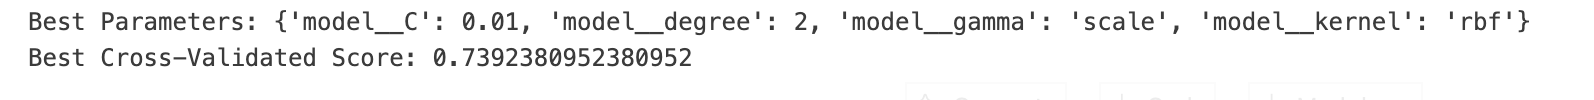

##### Model: Stochastic Gradient Descent


In [ ]:
grid_search, pipeline = grid_search_model(
    model=SGDClassifier(random_state=1),
    param_grid={
        'model__loss': ['hinge', 'log_loss'],
        'model__penalty': ['l2'],
        'model__alpha': [1e-4, 1e-3, 1e-2],
        'model__learning_rate': ['constant', 'optimal', 'invscaling'],
        'model__eta0': [0.001, 0.01],
        'model__average': [True, False]
    },
    data_folds=custom_folds,
    X=X,
    y=y,
    scaler=StandardScaler()
)

SGD_best_params = grid_search.best_params_
SGD_best_score = grid_search.best_score_

print("Best Parameters:", SGD_best_params)
print("Best Cross-Validated Score:", SGD_best_score)

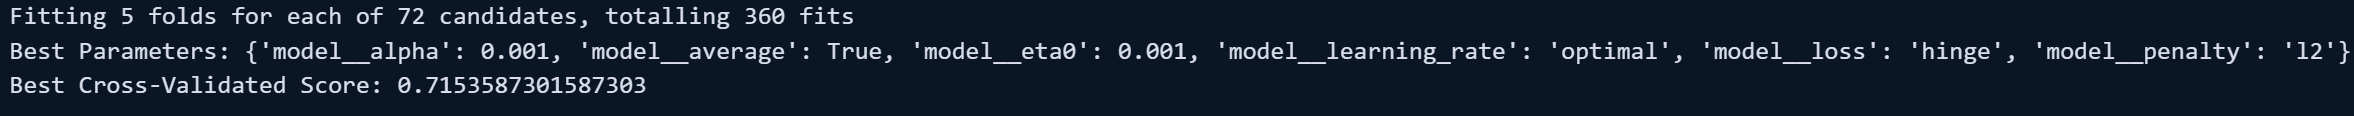

##### Model: Neural Networks

In [ ]:
grid_search, pipeline = grid_search_model(
    model=MLPClassifier(random_state=1, early_stopping=True, validation_fraction=0.1),
    param_grid={
        'model__hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
        'model__alpha': [1e-4, 1e-3, 1e-2],
        'model__activation': ['relu'],
        'model__max_iter': [200],
        'model__learning_rate': ['constant', 'adaptive'],
    },
    data_folds=custom_folds,
    X=X,
    y=y,
    scaler=StandardScaler()
)

neural_net_best_params = grid_search.best_params_
neural_net_best_score = grid_search.best_score_

print("Best Parameters:", neural_net_best_params)
print("Best Cross-Validated Score:", neural_net_best_score)

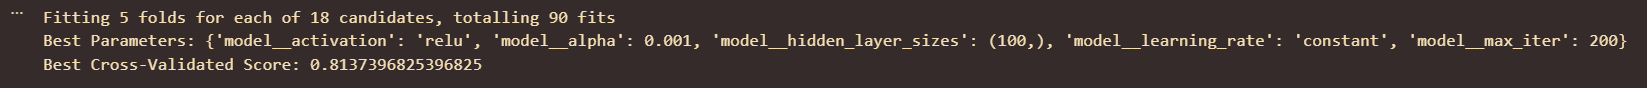

##### Model: Decision Trees

In [ ]:
grid_search, pipeline = grid_search_model(
    model=DecisionTreeClassifier(random_state=1),
    param_grid={
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 5, 10],
        'model__max_features': ['sqrt', None],
        'model__max_leaf_nodes': [None, 20, 50]
    },
    data_folds=custom_folds,
    X=X,
    y=y,
)

tree_best_params = grid_search.best_params_
tree_best_score = grid_search.best_score_

print("Best Parameters:", tree_best_params)
print("Best Cross-Validated Score:", tree_best_score)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': None, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Best Cross-Validated Score: 0.7321650793650794

## Model Comparison

### Choosing the most performant model

#### Results

After the cross-validation, we found it that the MLP model performed the best.


Model Comparison:

SVC: 0.7392

SGDClassifier: 0.7153

MLPClassifier: 0.8137

DecisionTreeClassifier: 0.7321

The DecisionTreeClassifier performed a bit better than SVC.
DecisionTreeClassifiers are prone to overfitting.
There is quite a bit less data to train on so the chances of overfitting are higher.

The SGDClassifier is a linear model and performed the worst.
This means that it is harder to capture complex patterns such as movements which is what we are trying to classify.
It is harder because it can only describe linear functions and not polynomials.
Whenever the data is more complex than a linear function simply can not classify the data correctly.
The SGDClassifier also requires very specific hyper paremeters for the learning rate and the feature scaling.
If these hyperparameters aren't set well the model can have trouble converging.

The SVC (Support Vector Classifier) performed the worst with an acuracy of 0.7392.
The SVC isn't a linear model since we use the rbf activation function.
This allows for capturing more complex patterns such as sport movements.
With this model the choice of the hyperparameters is also very important as it is with the SGDClassifier.

The MLPClassifier (Multi-Layer Perceptron) performed the best with an accuracy score of 0.8137. 
Since this model is already a neural network it is very good at capturing complex non-linear relationships in the data.
This type of model performs better with the more data it gets.
Although you need to be carefull of overfitting the model.


### Re-iterate with selected features

We found out that the MLPClassifier has the best performance so we will be using this model for our final evaluation.
We previously tried to define the most important features with the Decision Trees model.
However the decision tree model failed to find a good correlation between the keypoints and so the output we got for the important features was useless.

Therefor we will determine the most important features with logic.
The most information is stored in the body parts that move alot. The nose and the eyes don't really say anything about what movement is being done.
Or atleast not more than the left eye or left ear or something like that.
The features we want to remove are, the nose, left eye, right ear, left ear and perhaps also the neck.
The other features such as the keypoints that make out the arm are very important to determine what movement is being performed.

These features will now be removed and the model will be retrained to see if the performance is better or not.
And we will use the 'best' hyperparameters for the MLPClassifier.

In [142]:
def remove_keypoints(data, keypoints):
    cleaned_data = copy.deepcopy(data)
    
    for action_label, recordings in cleaned_data.items():
        for i, recording in enumerate(recordings):
            recording = list(recording)
            for j in range(len(recording)):
                recording[j] = np.delete(recording[j], keypoints, axis=0)
            recordings[i] = np.array(recording)
    
    return cleaned_data

keypoints = [0, 15, 16, 17]
selected_train_data = remove_keypoints(centered_train_data, keypoints)
selected_test_data = remove_keypoints(centered_test_data, keypoints)

# check if the keypoints are removed correctly
for action_label, recordings in selected_train_data.items():
    for recording in recordings:
        for frame in recording:
            assert frame.shape[0] == 18 - len(keypoints), "Incorrect number of keypoints"

In [143]:
folds = get_k_folds(selected_train_data, k_folds=5)
X, y, custom_folds = prepare_for_grid_search(folds, 450, 54 - len(keypoints)*3)

In [ ]:
grid_search, pipeline = grid_search_model(
    model=MLPClassifier(random_state=1, early_stopping=True, validation_fraction=0.1),
    param_grid={
        'model__hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
        'model__alpha': [1e-4, 1e-3, 1e-2],
        'model__activation': ['relu'],
        'model__max_iter': [200],
        'model__learning_rate': ['constant', 'adaptive'],
    },
    data_folds=custom_folds,
    X=X,
    y=y,
    scaler=StandardScaler()
)

neural_net_best_params = grid_search.best_params_
neural_net_best_score = grid_search.best_score_

print("Best Parameters:", neural_net_best_params)
print("Best Cross-Validated Score:", neural_net_best_score)

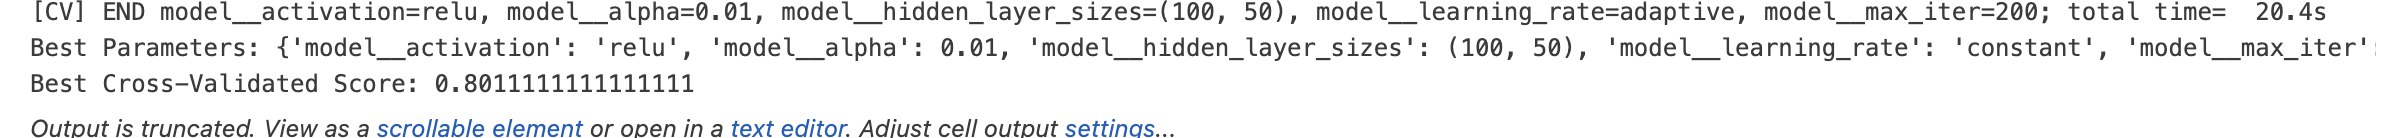

We have slightly worse accuracy with the removed keypoints. Because there are less keypoints, there is less data and because of this a neural network will perform worse.

# Final evaluation


### Training the final model


##### Reformatting the data
First of all we need to reformat the data so that it can be used to train and predict. 

In [144]:
def reformat_data_dict(data_dict):
    formatted_data = []
    labels = []

    for action_label, recordings in data_dict.items():
        for recording in recordings:
            for frame in recording:
                flat_frame = frame.flatten()
                formatted_data.append(flat_frame)
                labels.append(action_label)
    
    return np.array(formatted_data), np.array(labels)

train_data_formatted, train_lables = reformat_data_dict(centered_train_data)
test_data_formatted, test_labels = reformat_data_dict(centered_test_data)

print(f"Final Training data shape: {train_data_formatted.shape}, Labels shape: {train_lables.shape}")
print(f"Final Test data shape: {test_data_formatted.shape}, Labels shape: {test_labels.shape}")

Final Training data shape: (157500, 54), Labels shape: (157500,)
Final Test data shape: (25200, 54), Labels shape: (25200,)


##### Training & testing the model with the full dataset

In [145]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.01, learning_rate='constant', max_iter=200, random_state=1))
])

final_pipeline.fit(train_data_formatted, train_lables)

test_pred = final_pipeline.predict(test_data_formatted)

accuracy = accuracy_score(test_labels, test_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.83


The accuracy of the final model 0.83

### Construct a confusion matrix

<Figure size 640x480 with 0 Axes>

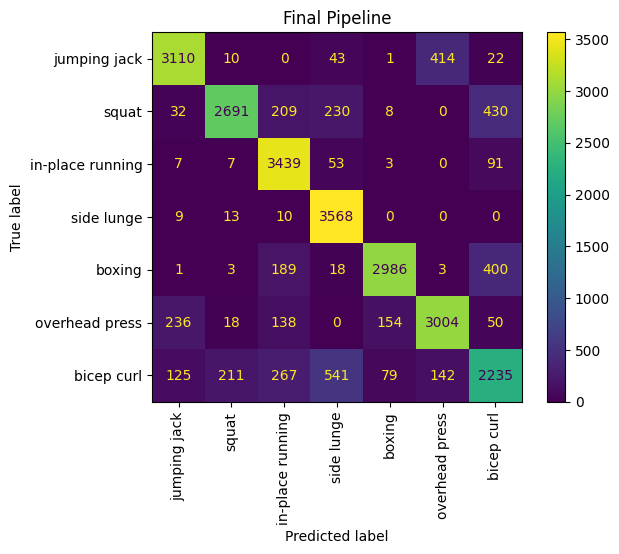

In [146]:
labels = ['jumping jack', 'squat', 'in-place running', 'side lunge', 'boxing', 'overhead press', 'bicep curl']
plt.figure()

disp = ConfusionMatrixDisplay.from_estimator(final_pipeline, test_data_formatted, test_labels, display_labels=labels, xticks_rotation='vertical')
plt.title('Final Pipeline')

plt.show()

### Visualize some missclassifications

In [147]:
from collections import defaultdict

def plot_misclassifications(X_test, y_test, y_pred, class_names, num_samples=3):
    
    misclassified_indices = np.where(y_test != y_pred)[0]
    misclassified_by_class = defaultdict(list)
    
    for index in misclassified_indices:
        true_label = y_test[index]
        misclassified_by_class[true_label].append(index)
    
    
    selected_indices = []
    for indices in misclassified_by_class.values():
        if len(selected_indices) < num_samples:
            selected_indices.append(indices[0])  
    
    
    fig, axes = plt.subplots(1, len(selected_indices), figsize=(15, 5))
    fig.suptitle("Misclassified Samples with Predicted and True Labels", fontsize=16)
    
    for i, index in enumerate(selected_indices):
        
        frame = X_test[index].reshape(18, 3)
        true_label = y_test[index]
        predicted_label = y_pred[index]
        
        
        x_coords = frame[:, 0]
        y_coords = frame[:, 1]
        
        
        ax = axes[i]
        ax.scatter(x_coords, y_coords, c='blue', marker='o')
        ax.invert_yaxis()
        
        
        ax.set_title(f"True: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}", 
                     color="red" if true_label != predicted_label else "black")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

    plt.tight_layout(rect=[0, 0, 1, 0.9])  
    plt.show()

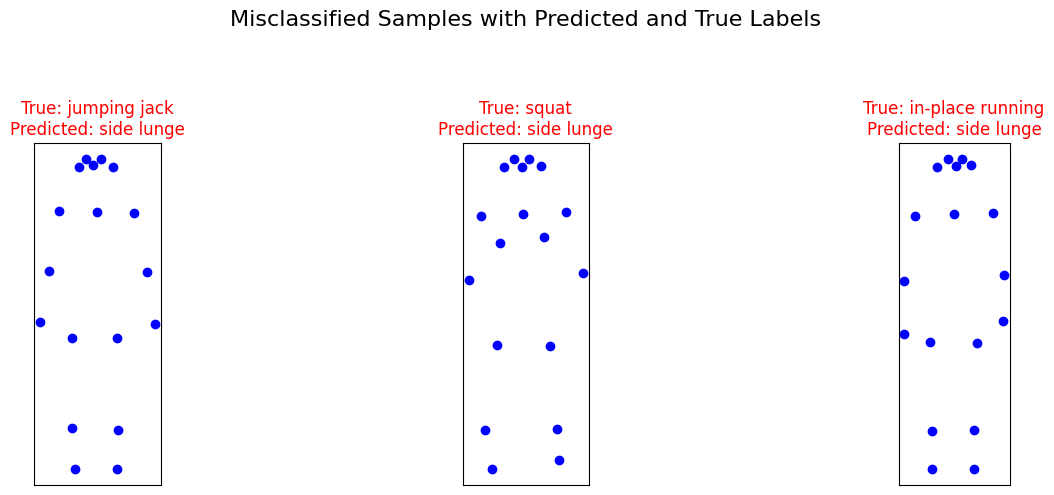

In [148]:
labels = ['jumping jack', 'squat', 'in-place running', 'side lunge', 'boxing', 'overhead press', 'bicep curl']

plot_misclassifications(test_data_formatted, test_labels, test_pred, labels)

As you can see, the misclassifications come from the fact that a lot of actions have overlapping positions at certain frames.

### Disadvantages of the frame-by-frame model

- Since an action is a sequence of frames, a lot of valuable information is lost. Because different actions might have similar positions and so frames might get missclassified. You lose the temporal context.
- Each frame is independently classified, which can make the model highly sensitive to noise or anomalies in individual frames.

#### Additional steps

- Looking at the precision, the recall and drawing conclusions out of it.
- You could use a different method to identify the least important keypoints and remove those.
- Examine the confidence of the misclassified keypoints
